In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
train=pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
 7   pressure   float64
dtypes: float64(3), int64(5)
memory usage: 368.4 MB


In [4]:
train.isnull().sum()

id           0
breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
pressure     0
dtype: int64

<AxesSubplot:>

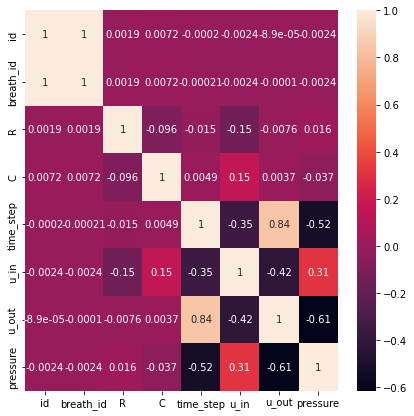

In [5]:
plt.rcParams['figure.figsize']=(7,7)
sns.heatmap(train.corr(),annot=True)

In [6]:
categorical_columns=['R','C','u_out']
numerical_columns=['time_step','u_in','pressure']

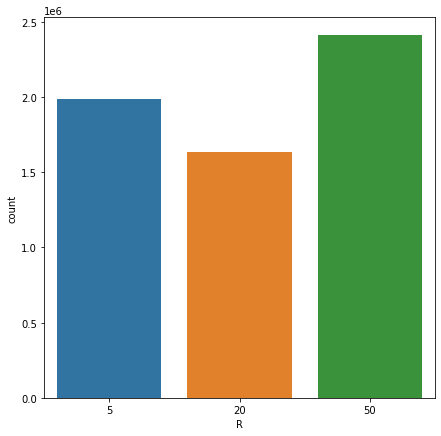

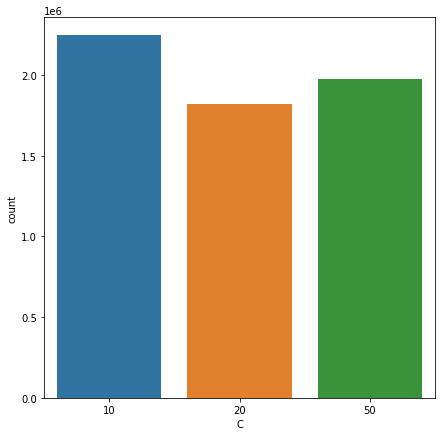

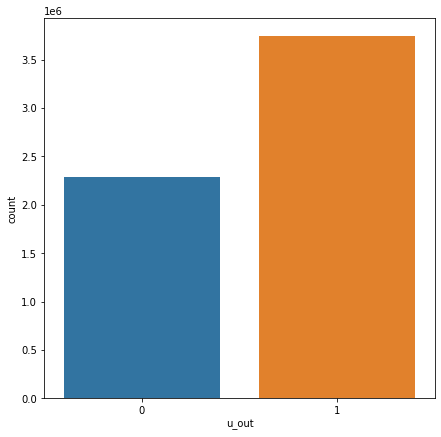

In [7]:
for i in categorical_columns:
    sns.countplot(train[i])
    plt.show()

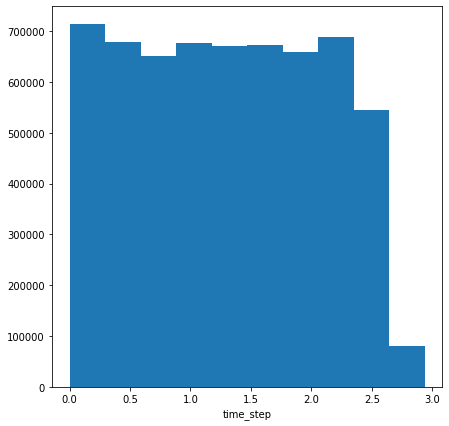

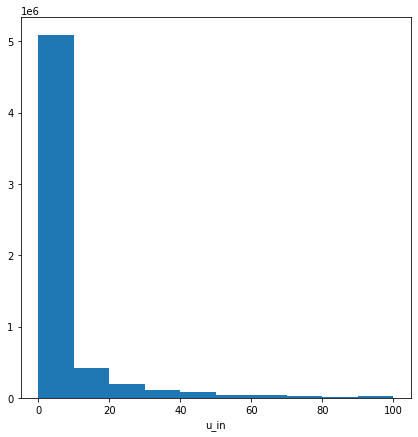

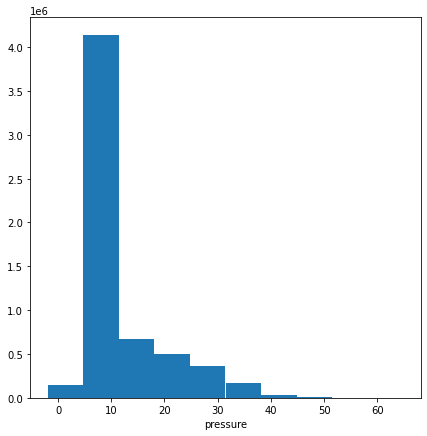

In [8]:
for i in numerical_columns:
    plt.hist(train[i])
    plt.xlabel(i)
    plt.show()

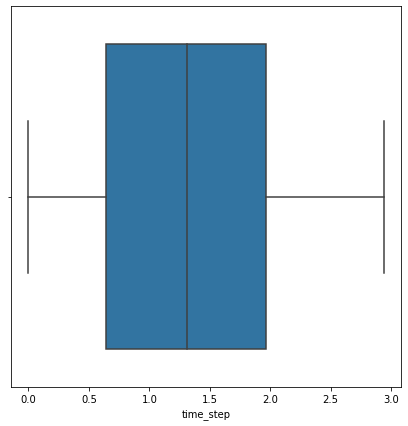

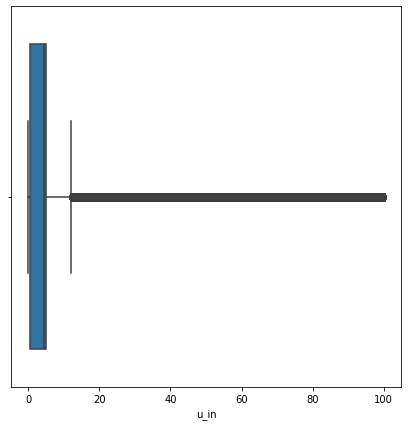

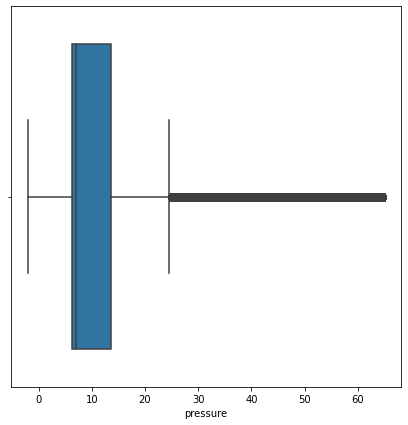

In [9]:
for i in numerical_columns:
    sns.boxplot(x=i,data=train)
    plt.show()

In [10]:
from scipy import stats

def no_of_outliers(col):
    iqr=stats.iqr(train[col])
    uplim=train[col].quantile(0.75)+(1.5*iqr)
    print('Total Outliers present are:',len(train[train[col]>uplim]))
    return ('Percentage of Outliers in the column:',round((len(train[train[col]>uplim])/len(train)*100),2))

In [11]:
no_of_outliers('time_step')

Total Outliers present are: 0


('Percentage of Outliers in the column:', 0.0)

In [12]:
no_of_outliers('u_in')

Total Outliers present are: 836873


('Percentage of Outliers in the column:', 13.86)

In [13]:
no_of_outliers('pressure')

Total Outliers present are: 594709


('Percentage of Outliers in the column:', 9.85)

We can ignore the outliers as their not many significant number of them as compared to the whole dataset

In [14]:
#Dropping 'id' and 'breath_id' columns as they are just unique ids for each record and each breath respectively 
train1=train.drop(['id','breath_id'],axis=1)
train1.head()

,R,C,time_step,u_in,u_out,pressure
0,20,50,0.000000,0.083334,0,5.837492
1,20,50,0.033652,18.383041,0,5.907794
2,20,50,0.067514,22.509278,0,7.876254
3,20,50,0.101542,22.808822,0,11.742872
4,20,50,0.135756,25.355850,0,12.234987


In [15]:
x=train1.drop('pressure',axis=1)
y=train1['pressure']

In [16]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.25,random_state=47)
print(xtrain.shape,ytrain.shape,xtest.shape,ytest.shape)

(4527000, 5) (4527000,) (1509000, 5) (1509000,)


In [18]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
sc1=StandardScaler()

Defining 2 different variables for Standard Scaling x and y parts as number of columns are different and will be used at the end while inverse transforming our predicted values

In [19]:
xtrain=sc.fit_transform(xtrain)
xtest=sc.transform(xtest)

In [20]:
ytrain=sc1.fit_transform(ytrain.values.reshape(-1,1))
ytest=sc1.transform(ytest.values.reshape(-1,1))

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

2021-10-09 12:54:43.507654: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [33]:
model=Sequential()
model.add(Dense(1024,input_dim=5,kernel_initializer='normal',activation='relu'))
model.add(Dense(512,kernel_initializer='normal',activation='relu'))
model.add(Dense(256,kernel_initializer='normal',activation='relu'))
model.add(Dense(128,kernel_initializer='normal',activation='relu'))
model.add(Dense(64,kernel_initializer='normal',activation='relu'))
model.add(Dense(32,kernel_initializer='normal',activation='relu'))
model.add(Dense(16,kernel_initializer='normal',activation='relu'))
model.add(Dense(8,kernel_initializer='normal',activation='relu'))
model.add(Dense(1,kernel_initializer='normal'))

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 1024)              6144      
_________________________________________________________________
dense_17 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_19 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_20 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_21 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_22 (Dense)             (None, 16)               

In [35]:
model.compile(loss='mean_absolute_error',optimizer='adam')

Requirement to run in GPU Accelerator

In [36]:
history=model.fit(xtrain,ytrain,validation_data=(xtest,ytest),epochs=100,batch_size=1000)

Epoch 1/100
4527/4527 [==============================] - 15s 3ms/step - loss: 0.3063 - val_loss: 0.2605
Epoch 2/100
4527/4527 [==============================] - 13s 3ms/step - loss: 0.2609 - val_loss: 0.2610
Epoch 3/100
4527/4527 [==============================] - 13s 3ms/step - loss: 0.2584 - val_loss: 0.2560
Epoch 4/100
4527/4527 [==============================] - 14s 3ms/step - loss: 0.2570 - val_loss: 0.2542
Epoch 5/100
4527/4527 [==============================] - 13s 3ms/step - loss: 0.2557 - val_loss: 0.2546
Epoch 6/100
4527/4527 [==============================] - 14s 3ms/step - loss: 0.2557 - val_loss: 0.2542
Epoch 7/100
4527/4527 [==============================] - 13s 3ms/step - loss: 0.2549 - val_loss: 0.2539
Epoch 8/100
4527/4527 [==============================] - 14s 3ms/step - loss: 0.2543 - val_loss: 0.2521
Epoch 9/100
4527/4527 [==============================] - 13s 3ms/step - loss: 0.2536 - val_loss: 0.2521
Epoch 10/100
4527/4527 [==============================] - 13s 3m

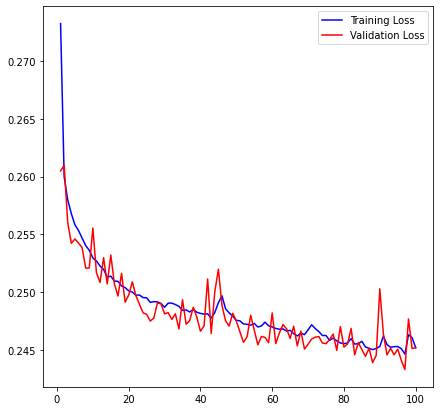

In [42]:
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.legend(loc='best')
plt.show()

In [53]:
ypred=model.predict(xtest)
ypred

array([[-0.54292506],
       [ 0.5527325 ],
       [-0.6867037 ],
       ...,
       [-0.56047755],
       [-0.7466458 ],
       [-0.3229755 ]], dtype=float32)

In [54]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

In [55]:
mse=mean_squared_error(ytest,ypred)
rmse=np.sqrt(mse)
rmse

0.5098578078601002

In [56]:
mae=mean_absolute_error(ytest,ypred)
mae

0.24518185510148

In [59]:
absolute_errors=abs(ypred-ytest)
absolute_errors

array([[0.06020552],
       [0.03794093],
       [0.02291066],
       ...,
       [0.01665483],
       [0.03952247],
       [0.01150713]])

In [64]:
r2_score(ytest,ypred)

0.7393643413597021

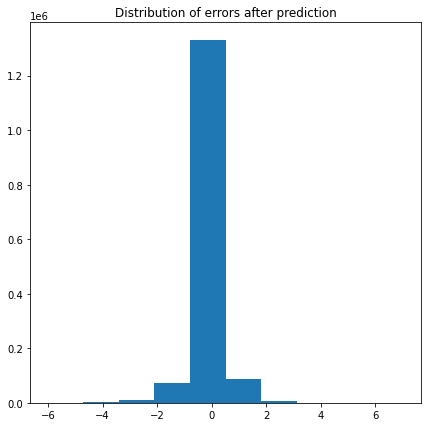

In [60]:
residuals=ypred-ytest
plt.hist(residuals)
plt.title('Distribution of errors after prediction')
plt.show()

Residuals are Normally Distributed

In [61]:
#Inverse Transforming with standard scale variable defined for ytrain and ytest parts
ypred_or=sc1.inverse_transform(ypred)
ypred_or

array([[ 6.818015 ],
       [15.706373 ],
       [ 5.6516323],
       ...,
       [ 6.675623 ],
       [ 5.165361 ],
       [ 8.602323 ]], dtype=float32)

**Bringing in the unseen 'test' data**

In [65]:
test=pd.read_csv('../input/ventilator-pressure-prediction/test.csv')
test.head()

,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


*Performing same data cleaning,preparing and exploring techniques on test data as done with train data*

In [67]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024000 entries, 0 to 4023999
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
dtypes: float64(2), int64(5)
memory usage: 214.9 MB


In [68]:
test.shape

(4024000, 7)

In [69]:
test.isnull().sum()

id           0
breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
dtype: int64

In [70]:
categorical_columns=['R','C','u_out']
numerical_columns=['time_step','u_in']

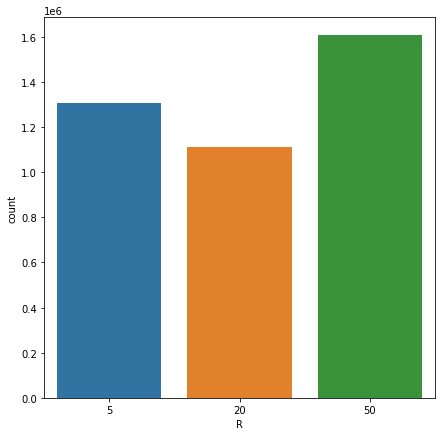

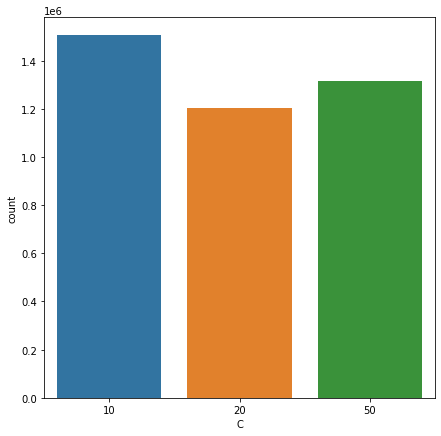

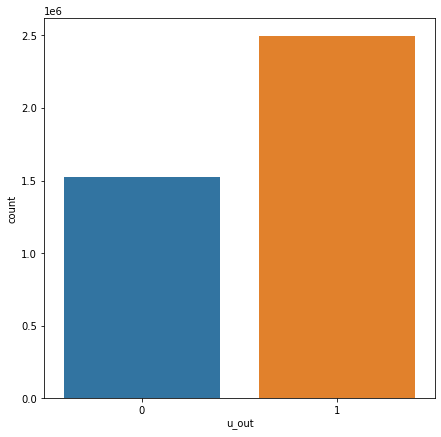

In [71]:
for i in categorical_columns:
    sns.countplot(test[i])
    plt.show()

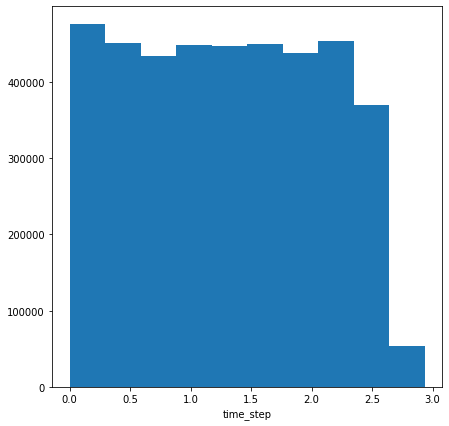

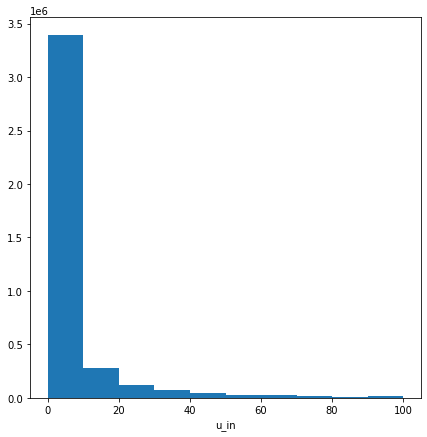

In [72]:
for i in numerical_columns:
    plt.hist(test[i])
    plt.xlabel(i)
    plt.show()

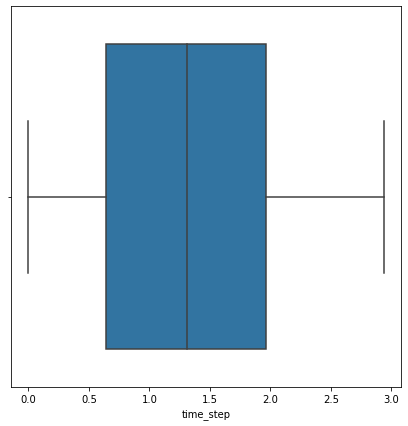

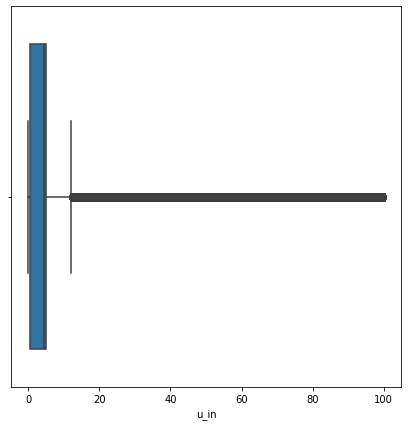

In [73]:
for i in numerical_columns:
    sns.boxplot(x=i,data=test)
    plt.show()

In [74]:
no_of_outliers('u_in')

Total Outliers present are: 836873


('Percentage of Outliers in the column:', 13.86)

In [75]:
test1=test.drop(['id','breath_id'],axis=1)
test1.head()

,R,C,time_step,u_in,u_out
0,5,20,0.000000,0.000000,0
1,5,20,0.031904,7.515046,0
2,5,20,0.063827,14.651675,0
3,5,20,0.095751,21.230610,0
4,5,20,0.127644,26.320956,0


In [76]:
#Using the standard scale variable defined for xtrain and xtest
test1=sc.transform(test1)
test1

array([[-1.12472248, -0.35455383, -1.70642857, -0.54513009, -1.27822663],
       [-1.12472248, -0.35455383, -1.66477953,  0.01434289, -1.27822663],
       [-1.12472248, -0.35455383, -1.62310466,  0.54564393, -1.27822663],
       ...,
       [-0.35917663, -0.9375728 ,  1.68446901, -0.17442341,  0.78233388],
       [-0.35917663, -0.9375728 ,  1.72840912, -0.17418665,  0.78233388],
       [-0.35917663, -0.9375728 ,  1.77301313, -0.17398378,  0.78233388]])

In [77]:
#Predicting pressure values with test1
prediction_values=model.predict(test1)
prediction_values

array([[-0.5999938 ],
       [-0.63751554],
       [-0.46392572],
       ...,
       [-0.6253625 ],
       [-0.6271016 ],
       [-0.61832076]], dtype=float32)

In [78]:
prediction_values_original=sc1.inverse_transform(prediction_values)
prediction_values_original

array([[6.3550534],
       [6.050664 ],
       [7.458885 ],
       ...,
       [6.1492534],
       [6.135145 ],
       [6.2063785]], dtype=float32)

In [79]:
predicted_df=pd.DataFrame(prediction_values_original)
predicted_df

,0
0,6.355053
1,6.050664
2,7.458885
3,8.110691
4,9.923294
...,...
4023995,6.130960
4023996,6.159907
4023997,6.149253
4023998,6.135145


In [80]:
predicted_df=predicted_df.rename({0:'Predicted Pressure'},axis=1)
predicted_df

,Predicted Pressure
0,6.355053
1,6.050664
2,7.458885
3,8.110691
4,9.923294
...,...
4023995,6.130960
4023996,6.159907
4023997,6.149253
4023998,6.135145


In [81]:
#Importing the Sample Submission File
submission=pd.read_csv('../input/ventilator-pressure-prediction/sample_submission.csv')
submission

,id,pressure
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
4023995,4023996,0
4023996,4023997,0
4023997,4023998,0
4023998,4023999,0


In [82]:
submission['pressure']=predicted_df['Predicted Pressure']
submission

,id,pressure
0,1,6.355053
1,2,6.050664
2,3,7.458885
3,4,8.110691
4,5,9.923294
...,...,...
4023995,4023996,6.130960
4023996,4023997,6.159907
4023997,4023998,6.149253
4023998,4023999,6.135145


In [83]:
submission.to_csv('submission.csv',index=False)